In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using the built in PyTorch MNIST dataset, we perform some transformations.

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 156439638.64it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83484282.44it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 57982254.57it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7427106.73it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Examining the data:

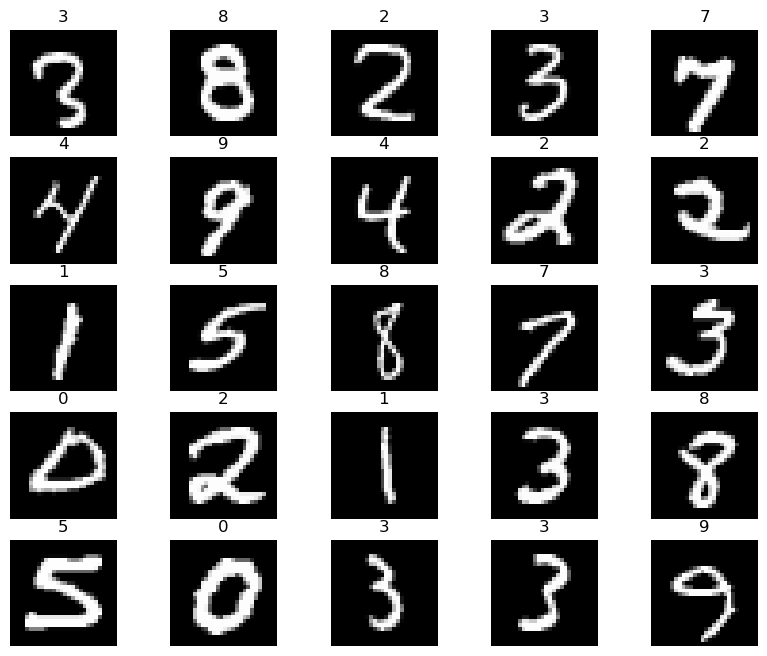

In [3]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

DataLoaders are necessary for letting the model process large datasets.

In [4]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
    'test' : torch.utils.data.DataLoader(test_data,
                                         batch_size=100,
                                         shuffle=True,
                                         num_workers=1)
}

Next, we define the model as well as its forward pass function. This is a fairly simple CNN with 2 convolutional layers.

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,  # (int) -> number of channels in input image    =1 because output is grayscale image
                out_channels=16, # (int) -> number of channels produced by the convolution
                kernel_size=5, # (int, tuple) -> size of convolving kernel
                stride=1, # (int, tuple, optional) -> stride of convolution, default is 1
                padding=2, # (int, tuple, optional) -> zero-padding added to both sides of input, default is 0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x       

In [6]:
cnn = CNN()

Next we define the loss function and optimizer. Cross Entropy Loss is a loss function for classification problems, while Adam is a popular and powerful optimizer that extends the already effective stochastic gradient descent algorithm.

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)  

It is worthwhile to check and make sure what device we are running on. 

In [1]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NameError: name 'torch' is not defined

Next is the training step. As this is a convolutional neural network being trained on a large image dataset, expect training time to take much longer than for a simple linear regression model. It is also worthwhile to time the training loop.

In [19]:
import time
start_time = time.time()

In [8]:
num_epochs = 10
def train(num_epochs, cnn, loaders):
    cnn.train()
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalizes x when iterating train_loader
            b_x = Variable(images)
            b_y = Variable(labels)
            
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this trainign step
            optimizer.zero_grad()
            # backpropogation, computing gradients
            loss.backward()
            # apply gradients
            optimizer.step()
            if (i+1) & 100 == 0:
                print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i+1, total_step, loss.item()))
                pass
            pass
        pass
train(num_epochs, cnn, loaders)



Epoch [1/10], Step[1/600], Loss: 2.3085
Epoch [1/10], Step[2/600], Loss: 2.3335
Epoch [1/10], Step[3/600], Loss: 2.1627
Epoch [1/10], Step[8/600], Loss: 0.9446
Epoch [1/10], Step[9/600], Loss: 0.7256
Epoch [1/10], Step[10/600], Loss: 1.0656
Epoch [1/10], Step[11/600], Loss: 0.9062
Epoch [1/10], Step[16/600], Loss: 0.3464
Epoch [1/10], Step[17/600], Loss: 0.3734
Epoch [1/10], Step[18/600], Loss: 0.3761
Epoch [1/10], Step[19/600], Loss: 0.3033
Epoch [1/10], Step[24/600], Loss: 0.2826
Epoch [1/10], Step[25/600], Loss: 0.3733
Epoch [1/10], Step[26/600], Loss: 0.3239
Epoch [1/10], Step[27/600], Loss: 0.2235
Epoch [1/10], Step[128/600], Loss: 0.0396
Epoch [1/10], Step[129/600], Loss: 0.1523
Epoch [1/10], Step[130/600], Loss: 0.0681
Epoch [1/10], Step[131/600], Loss: 0.0908
Epoch [1/10], Step[136/600], Loss: 0.0635
Epoch [1/10], Step[137/600], Loss: 0.0415
Epoch [1/10], Step[138/600], Loss: 0.0911
Epoch [1/10], Step[139/600], Loss: 0.0752
Epoch [1/10], Step[144/600], Loss: 0.1159
Epoch [1/10]

In [20]:
curr_time = time.time()
print(f"Training took {curr_time - start_time} seconds")

Training took 32.58645701408386 seconds


Defining a testing function for model evaluation:

In [9]:
def test():
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test accuracy of model on 10000 test images: %.2f' % accuracy)
    pass
test()

Test accuracy of model on 10000 test images: 1.00


In [10]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()

In [11]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [2 9 2 3 0 1 4 2 0 4]
Actual number: [2 9 2 3 0 1 4 2 0 4]


Next, we can save the trained model's state using the lines below:

In [15]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_mnist_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=cnn.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_mnist_cnn.pth


In [16]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = CNN()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [18]:
loaded_model_0.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        test_output, last_layer = loaded_model_0(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test accuracy of model on 10000 test images: %.2f' % accuracy)

Test accuracy of model on 10000 test images: 0.99
